# 🔬 SKINDX: Class Balancing & Model Training

**Advanced Techniques for Imbalanced Medical Data**

---

🎯 **Notebook Overview**

Building on our data exploration, this notebook tackles the critical challenge of **extreme class imbalance** in the HAM10000 dataset and develops high-performance classification models.

**Key Challenge**: Nevus (nv) has 6,705 samples while Dermatofibroma (df) has only 115 samples - a 58:1 ratio!

---

📋 **What We'll Accomplish**

We will address class imbalance using **Smart Augmentation** with class-specific rates (1x to 50x multipliers) and train a **ResNet-based CNN** with **Data Augmentation** strategies.  

We have tried several experiments tracked with **MLflow**, and the best result achieved was **87% accuracy**, with the best precision/recall across all 7 classes.

The best trained model is exported locally, logged with MLflow, and published on the Hugging Face Hub for easy reuse and reproducibility.

For full details, please refer to the complete notebook on GitHub:  
🔗 [04_skin_ham10000_pt.ipynb](https://github.com/lisekarimi/pixdl/blob/main/04_skin_ham10000_pt.ipynb)  


---

🛠️ **Technical Stack**  

- **Tracking**: MLflow for experiment management and artifact storage  
- **Augmentation**: Advanced torchvision transforms + class-specific augmentation for medical images  
- **Models**: PyTorch implementation using **ResNet** with GPU acceleration  
- **Evaluation**: Comprehensive metrics including per-class performance  

---

⚡ **GPU Acceleration Requirement**

This project is tuned for **NVIDIA RTX 5080**.  
If you use a different GPU, adjust parameters such as `batch_size`, `num_workers`, and resource settings in `docker-compose.yml`:

```yaml
ipc: "host"
ulimits:
  memlock: -1
  stack: 67108864
```

## 📚 Import Libraries 

In [1]:
# ============================================================================
# STANDARD LIBRARY IMPORTS
# ============================================================================
import os
import sys
import time
import tempfile
import subprocess
import random
import importlib
from glob import glob

# ============================================================================
# THIRD-PARTY DATA & COMPUTATION LIBRARIES
# ============================================================================
import numpy as np
import pandas as pd

# ============================================================================
# VISUALIZATION LIBRARIES
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# MACHINE LEARNING & DATA SCIENCE LIBRARIES
# ============================================================================
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

# ============================================================================
# DEEP LEARNING - PyTorch Core
# ============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ============================================================================
# DEEP LEARNING - Computer Vision
# ============================================================================
import torchvision.models as models
from torchvision import transforms
from PIL import Image

# ============================================================================
# PROGRESS TRACKING & UTILITIES
# ============================================================================
from tqdm import tqdm

# ============================================================================
# EXPERIMENT TRACKING & API
# ============================================================================
import mlflow
import requests

# ============================================================================
# PROJECT MODULES
# ============================================================================
sys.path.append(os.path.dirname(os.getcwd()))
from helpers.cnn_trainer import train_cnn_model

# ============================================================================
# CONFIG
# ============================================================================
input_path = "../data/HAM10000/"
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USER_NAME = "lisekarimi"
EXPERIMENT_NAME = "skindx ham10000"

In [2]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0)}")

CUDA available: True
Device: NVIDIA GeForce RTX 5080


## ⚙️ Setup MLflow locally

In [3]:
MLFLOW_URI = "http://localhost:5000"

def is_mlflow_running():
    try:
        return requests.get(f"{MLFLOW_URI}/health", timeout=2).ok
    except Exception:
        return False

if not is_mlflow_running():
    print("Starting MLflow server...")
    env = os.environ.copy()
    env["GUNICORN_CMD_ARGS"] = "--log-level warning --access-logfile /dev/null --error-logfile -"
    subprocess.Popen(
        ["mlflow","server","--host","0.0.0.0","--port","5000",
         "--backend-store-uri","file:///workspace/notebooks/mlflow_storage",
         "--default-artifact-root","file:///workspace/notebooks/mlflow_storage/mlartifacts"],
        env=env, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
    )
    # wait until healthy (max ~10s)
    for _ in range(20):
        if is_mlflow_running():
            break
        time.sleep(0.5)
else:
    print("MLflow server already running!")

mlflow.set_tracking_uri(MLFLOW_URI)

exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if exp is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
    print(f"Created new experiment with ID: {experiment_id}")
else:
    experiment_id = exp.experiment_id
    print(f"Using existing experiment with ID: {experiment_id}")

mlflow.set_experiment(EXPERIMENT_NAME)
print("MLflow setup complete!")


Starting MLflow server...
Created new experiment with ID: 588572262053754225
MLflow setup complete!


## 📥 Load Metadata

In [4]:
metadata = pd.read_csv(os.path.join(input_path, "HAM10000_metadata.csv"))
display(metadata.head())

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
# Create image path mapping
image_path = {}
for part in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
    folder_path = os.path.join(input_path, part)
    part_images = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(folder_path, '*.jpg'))}
    image_path.update(part_images)

print(f"Found {len(image_path)} images")

# Add labels and paths to metadata
metadata['label'] = metadata['dx'].map(lambda x: label_names.index(x))
metadata['path'] = metadata['image_id'].map(image_path.get)

metadata.head()

Found 10015 images


,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,../data/HAM10000/HAM10000_images_part_1/ISIC_0...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,../data/HAM10000/HAM10000_images_part_1/ISIC_0...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,../data/HAM10000/HAM10000_images_part_1/ISIC_0...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,../data/HAM10000/HAM10000_images_part_1/ISIC_0...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,../data/HAM10000/HAM10000_images_part_2/ISIC_0...


## ✂️ Split Data (SPLIT FIRST - No Data Leakage!)

In [6]:
# SPLIT FIRST - by unique images to avoid any overlap
train_df, test_df = train_test_split(
    metadata,
    test_size=0.2,
    random_state=42,
    stratify=metadata['label']
)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.25,
    random_state=42,
    stratify=train_df['label']
)

print(f"After splitting:")
print(f"Train: {len(train_df)} samples")
print(f"Val: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

After splitting:
Train: 6009 samples
Val: 2003 samples
Test: 2003 samples


## ⚖️ Balance Training Data Only
Were are going to use class-specific multiplication rates:

- Small classes get big multipliers: df × 50, akiec × 15, vasc × 40
- Large classes get small multipliers: nv × 1 (unchanged)
- Medium classes get medium multipliers: bcc × 10, mel × 5

In [7]:
# Balance multipliers for each class
data_aug_rate = [15, 10, 5, 50, 5, 1, 40]

def balance_training_data(train_df, data_aug_rate):
    """Balance only the training data by duplicating minority classes"""
    balanced_dfs = []

    for class_idx, rate in enumerate(data_aug_rate):
        class_df = train_df[train_df['label'] == class_idx]
        if len(class_df) > 0 and rate > 0:
            # Multiply the class by the rate
            augmented_df = pd.concat([class_df] * rate, ignore_index=True)
            balanced_dfs.append(augmented_df)

    return pd.concat(balanced_dfs, ignore_index=True)

# Balance only training data
train_df_balanced = balance_training_data(train_df, data_aug_rate)

print(f"\n✅ Balanced training set:")
print(train_df_balanced['label'].value_counts().sort_index())
print(f"Total balanced training samples: {len(train_df_balanced)}")

# Verify no image overlap between sets
def check_no_image_overlap(train_df, val_df, test_df):
    train_imgs = set(train_df['image_id'].unique())
    val_imgs = set(val_df['image_id'].unique())
    test_imgs = set(test_df['image_id'].unique())

    overlaps = [
        len(train_imgs.intersection(val_imgs)),
        len(train_imgs.intersection(test_imgs)),
        len(val_imgs.intersection(test_imgs))
    ]

    if sum(overlaps) == 0:
        print("✓ No image overlap between sets - clean split!")
    else:
        print(f"⚠ Warning: Image overlaps detected: {overlaps}")

check_no_image_overlap(train_df_balanced, val_df, test_df)


✅ Balanced training set:
label
0    2955
1    3080
2    3295
3    3450
4    3340
5    4023
6    3400
Name: count, dtype: int64
Total balanced training samples: 23543
✓ No image overlap between sets - clean split!


## 🖼️ Create Dataset and DataLoaders

In [8]:
# Custom Dataset class
class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_paths = dataframe['path'].values
        self.labels = dataframe['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, label

# Data transforms
input_size = 224
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

# Create datasets
train_dataset = SkinDataset(train_df_balanced, transform=train_transform)
val_dataset = SkinDataset(val_df, transform=val_transform)
test_dataset = SkinDataset(test_df, transform=val_transform)

# Create DataLoaders
torch.backends.cudnn.benchmark = True  # Optimize for fixed input sizes

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                         num_workers=4, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False,
                       num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False,
                        num_workers=4, pin_memory=True, persistent_workers=True)

## 🏋️‍♂️ Train ResNet Model

In [9]:
# Create model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(model.fc.in_features, 7)
)
model = model.to(device)

# Setup training
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print(f"✅ Model created and moved to {device}")

✅ Model created and moved to cuda


Epoch 1/150: 100%|██████████| 184/184 [01:08<00:00,  2.69it/s, loss=0.6365, accuracy=76.29%]


Epoch 1: loss: 0.6365 - accuracy: 76.29% - val_loss: 0.7471 - val_accuracy: 69.95%
Validation loss improved. Best model updated.


Epoch 2/150: 100%|██████████| 184/184 [00:54<00:00,  3.41it/s, loss=0.3399, accuracy=87.04%]


Epoch 2: loss: 0.3399 - accuracy: 87.04% - val_loss: 0.9234 - val_accuracy: 69.05%
No improvement. Patience: 1/20


Epoch 3/150: 100%|██████████| 184/184 [00:53<00:00,  3.42it/s, loss=0.2486, accuracy=90.71%]


Epoch 3: loss: 0.2486 - accuracy: 90.71% - val_loss: 0.9308 - val_accuracy: 70.64%
No improvement. Patience: 2/20


Epoch 4/150: 100%|██████████| 184/184 [00:54<00:00,  3.40it/s, loss=0.2129, accuracy=92.19%]


Epoch 4: loss: 0.2129 - accuracy: 92.19% - val_loss: 0.7037 - val_accuracy: 76.44%
Validation loss improved. Best model updated.


Epoch 5/150: 100%|██████████| 184/184 [00:54<00:00,  3.40it/s, loss=0.1759, accuracy=93.39%]


Epoch 5: loss: 0.1759 - accuracy: 93.39% - val_loss: 0.9065 - val_accuracy: 79.88%
No improvement. Patience: 1/20


Epoch 6/150: 100%|██████████| 184/184 [00:53<00:00,  3.43it/s, loss=0.1444, accuracy=94.61%]


Epoch 6: loss: 0.1444 - accuracy: 94.61% - val_loss: 0.6922 - val_accuracy: 77.48%
Validation loss improved. Best model updated.


Epoch 7/150: 100%|██████████| 184/184 [00:53<00:00,  3.45it/s, loss=0.1313, accuracy=95.22%]


Epoch 7: loss: 0.1313 - accuracy: 95.22% - val_loss: 0.6135 - val_accuracy: 82.13%
Validation loss improved. Best model updated.


Epoch 8/150: 100%|██████████| 184/184 [00:53<00:00,  3.44it/s, loss=0.1224, accuracy=95.63%]


Epoch 8: loss: 0.1224 - accuracy: 95.63% - val_loss: 0.6160 - val_accuracy: 83.33%
No improvement. Patience: 1/20


Epoch 9/150: 100%|██████████| 184/184 [00:53<00:00,  3.44it/s, loss=0.1001, accuracy=96.55%]


Epoch 9: loss: 0.1001 - accuracy: 96.55% - val_loss: 0.5875 - val_accuracy: 83.37%
Validation loss improved. Best model updated.


Epoch 10/150: 100%|██████████| 184/184 [00:53<00:00,  3.43it/s, loss=0.1061, accuracy=96.33%]


Epoch 10: loss: 0.1061 - accuracy: 96.33% - val_loss: 0.5561 - val_accuracy: 84.82%
Validation loss improved. Best model updated.


Epoch 11/150: 100%|██████████| 184/184 [00:54<00:00,  3.38it/s, loss=0.0930, accuracy=96.61%]


Epoch 11: loss: 0.0930 - accuracy: 96.61% - val_loss: 0.8154 - val_accuracy: 76.14%
No improvement. Patience: 1/20


Epoch 12/150: 100%|██████████| 184/184 [00:54<00:00,  3.40it/s, loss=0.0825, accuracy=97.06%]


Epoch 12: loss: 0.0825 - accuracy: 97.06% - val_loss: 0.5943 - val_accuracy: 85.07%
No improvement. Patience: 2/20


Epoch 13/150: 100%|██████████| 184/184 [00:54<00:00,  3.40it/s, loss=0.0791, accuracy=97.23%]


Epoch 13: loss: 0.0791 - accuracy: 97.23% - val_loss: 0.7419 - val_accuracy: 83.67%
No improvement. Patience: 3/20


Epoch 14/150: 100%|██████████| 184/184 [00:54<00:00,  3.39it/s, loss=0.0778, accuracy=97.34%]


Epoch 14: loss: 0.0778 - accuracy: 97.34% - val_loss: 0.5931 - val_accuracy: 84.87%
No improvement. Patience: 4/20


Epoch 15/150: 100%|██████████| 184/184 [00:54<00:00,  3.39it/s, loss=0.0762, accuracy=97.25%]


Epoch 15: loss: 0.0762 - accuracy: 97.25% - val_loss: 0.7397 - val_accuracy: 82.43%
No improvement. Patience: 5/20


Epoch 16/150: 100%|██████████| 184/184 [00:53<00:00,  3.42it/s, loss=0.0583, accuracy=98.00%]


Epoch 16: loss: 0.0583 - accuracy: 98.00% - val_loss: 0.6637 - val_accuracy: 83.77%
No improvement. Patience: 6/20


Epoch 17/150: 100%|██████████| 184/184 [00:53<00:00,  3.44it/s, loss=0.0241, accuracy=99.27%]


Epoch 17: loss: 0.0241 - accuracy: 99.27% - val_loss: 0.6436 - val_accuracy: 86.77%
No improvement. Patience: 7/20


Epoch 18/150: 100%|██████████| 184/184 [00:52<00:00,  3.48it/s, loss=0.0125, accuracy=99.59%]


Epoch 18: loss: 0.0125 - accuracy: 99.59% - val_loss: 0.7384 - val_accuracy: 86.82%
No improvement. Patience: 8/20


Epoch 19/150: 100%|██████████| 184/184 [00:52<00:00,  3.49it/s, loss=0.0133, accuracy=99.57%]


Epoch 19: loss: 0.0133 - accuracy: 99.57% - val_loss: 0.7613 - val_accuracy: 86.42%
No improvement. Patience: 9/20


Epoch 20/150: 100%|██████████| 184/184 [00:52<00:00,  3.48it/s, loss=0.0181, accuracy=99.44%]


Epoch 20: loss: 0.0181 - accuracy: 99.44% - val_loss: 0.7035 - val_accuracy: 85.97%
No improvement. Patience: 10/20


Epoch 21/150: 100%|██████████| 184/184 [00:52<00:00,  3.48it/s, loss=0.0141, accuracy=99.51%]


Epoch 21: loss: 0.0141 - accuracy: 99.51% - val_loss: 0.7775 - val_accuracy: 86.82%
No improvement. Patience: 11/20


Epoch 22/150: 100%|██████████| 184/184 [00:52<00:00,  3.48it/s, loss=0.0185, accuracy=99.40%]


Epoch 22: loss: 0.0185 - accuracy: 99.40% - val_loss: 0.7927 - val_accuracy: 86.42%
No improvement. Patience: 12/20


Epoch 23/150: 100%|██████████| 184/184 [00:52<00:00,  3.48it/s, loss=0.0071, accuracy=99.79%]


Epoch 23: loss: 0.0071 - accuracy: 99.79% - val_loss: 0.7741 - val_accuracy: 87.17%
No improvement. Patience: 13/20


Epoch 24/150: 100%|██████████| 184/184 [00:52<00:00,  3.48it/s, loss=0.0054, accuracy=99.82%]


Epoch 24: loss: 0.0054 - accuracy: 99.82% - val_loss: 0.7969 - val_accuracy: 87.22%
No improvement. Patience: 14/20


Epoch 25/150: 100%|██████████| 184/184 [00:52<00:00,  3.48it/s, loss=0.0044, accuracy=99.85%]


Epoch 25: loss: 0.0044 - accuracy: 99.85% - val_loss: 0.8642 - val_accuracy: 87.17%
No improvement. Patience: 15/20


Epoch 26/150: 100%|██████████| 184/184 [00:53<00:00,  3.46it/s, loss=0.0044, accuracy=99.88%]


Epoch 26: loss: 0.0044 - accuracy: 99.88% - val_loss: 0.7719 - val_accuracy: 87.12%
No improvement. Patience: 16/20


Epoch 27/150: 100%|██████████| 184/184 [00:53<00:00,  3.46it/s, loss=0.0068, accuracy=99.77%]


Epoch 27: loss: 0.0068 - accuracy: 99.77% - val_loss: 0.8107 - val_accuracy: 86.72%
No improvement. Patience: 17/20


Epoch 28/150: 100%|██████████| 184/184 [00:53<00:00,  3.44it/s, loss=0.0055, accuracy=99.83%]


Epoch 28: loss: 0.0055 - accuracy: 99.83% - val_loss: 0.7571 - val_accuracy: 87.22%
No improvement. Patience: 18/20


Epoch 29/150: 100%|██████████| 184/184 [00:53<00:00,  3.43it/s, loss=0.0031, accuracy=99.90%]


Epoch 29: loss: 0.0031 - accuracy: 99.90% - val_loss: 0.7909 - val_accuracy: 88.07%
No improvement. Patience: 19/20


Epoch 30/150: 100%|██████████| 184/184 [00:53<00:00,  3.46it/s, loss=0.0020, accuracy=99.94%]


Epoch 30: loss: 0.0020 - accuracy: 99.94% - val_loss: 0.8446 - val_accuracy: 87.27%
No improvement. Patience: 20/20
Early stopping triggered after 30 epochs
Best model from epoch 10 loaded

Test Results:
Test Loss: 0.7874
Test Accuracy: 88.07%


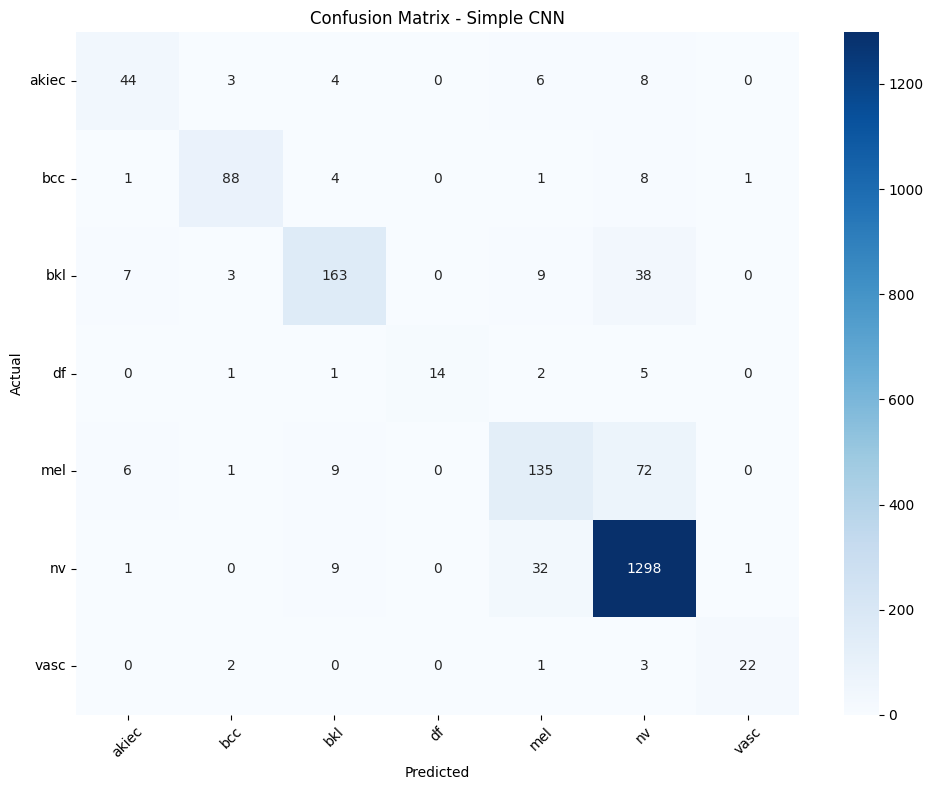

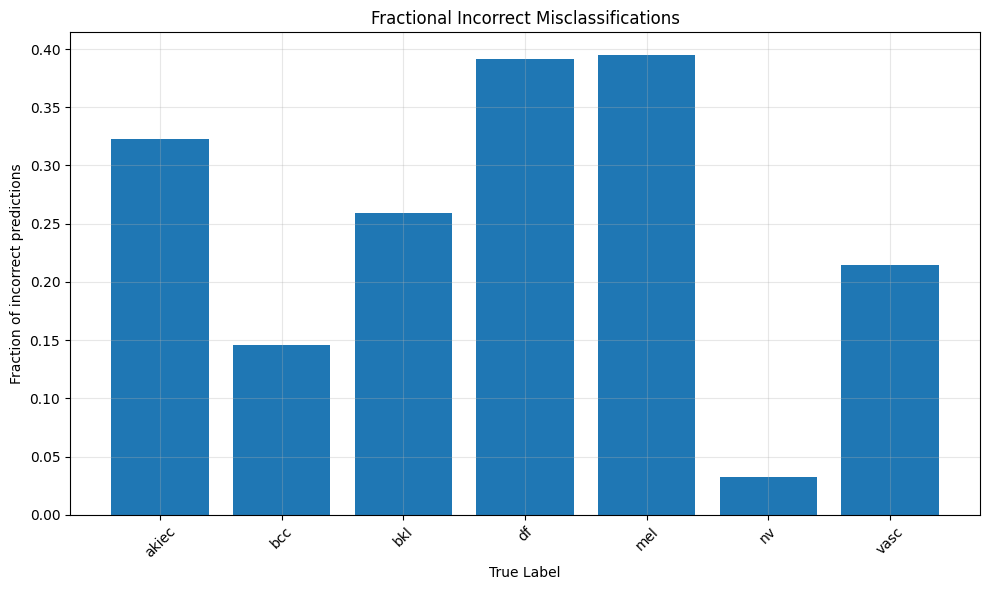


Classification Report:
              precision    recall  f1-score   support

       akiec       0.75      0.68      0.71        65
         bcc       0.90      0.85      0.88       103
         bkl       0.86      0.74      0.80       220
          df       1.00      0.61      0.76        23
         mel       0.73      0.61      0.66       223
          nv       0.91      0.97      0.94      1341
        vasc       0.92      0.79      0.85        28

    accuracy                           0.88      2003
   macro avg       0.86      0.75      0.80      2003
weighted avg       0.88      0.88      0.88      2003



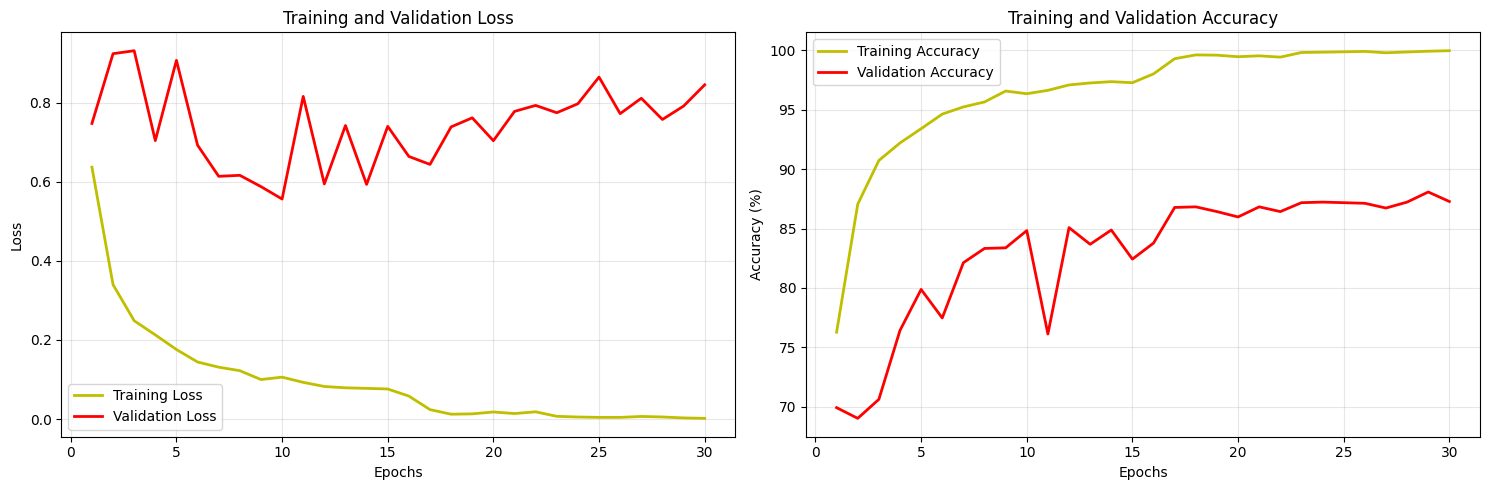

2025/08/30 15:50:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/30 15:50:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/30 15:50:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🎉 TRAINING COMPLETED SUCCESSFULLY! 🎉
✅ Total epochs trained: 30
✅ Best epoch: 10
✅ Final test accuracy: 88.07%
✅ Model saved to MLflow
✅ All artifacts logged successfully
Training and evaluation completed!
🏃 View run ResNet at: http://localhost:5000/#/experiments/588572262053754225/runs/e3c45c30db01411f9b8c40aa82ec7f20
🧪 View experiment at: http://localhost:5000/#/experiments/588572262053754225


In [10]:
train_losses, val_losses, train_accs, val_accs, test_loss, test_acc = train_cnn_model(
    model, train_loader, val_loader, test_loader,
    criterion, optimizer,
    data_balancing="class-specific augmentation rates",
    scheduler=scheduler,
    num_epochs=150, patience=20, image_size=224, data_augmentation=True,
    notes="ResNet50-DA-SplitFirst-ClassAug-Scheduler-Drop0.1-L2",
    user_name=USER_NAME,
    device=device,
    label_names=label_names
)

The model shows signs of overfitting, with training accuracy reaching ~99% while validation and test accuracy plateau around ~88%.
Still, overall performance is strong, with recall above 60% for all classes.

Although the relatively lower recall for melanoma is a concern given its clinical importance, this version provides a solid and reliable baseline.

We will keep it as the best performance achieved so far and focus on improving future versions through stronger regularization, class balancing, and augmentation to enhance generalization, particularly for minority and critical classes.

## 💾 Save the Model  
Store the trained model locally.

In [13]:
!pwd

/workspace/notebooks/HAM10000


In [15]:
# Load the model with weights_only=False (since we trust our own model)
model_path = "/workspace/notebooks/mlflow_storage/mlartifacts/588572262053754225/models/m-973141f64c1143b6aa376552f0f5c0f9/artifacts/data/model.pth"
model = torch.load(model_path, weights_only=False)

os.makedirs("/workspace/models/", exist_ok=True)
torch.save(model, "/workspace/models/resnet50_v010.pth")  # Save FULL model
print("✅ Full model saved - ready for Inference!")

✅ Full model saved - ready for Inference!


**Deploy the model to Hugging Face using an API token stored securely in your .env file.**

In [2]:
from huggingface_hub import HfApi, upload_file
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Initialize API
api = HfApi()

# Create the repository first
api.create_repo(
    repo_id="lisekarimi/resnet50-ham10000",
    repo_type="model",
    token=os.getenv("HUGGINGFACE_HUB_TOKEN")
)

# Now upload the file
upload_file(
    path_or_fileobj="/workspace/models/resnet50_v010.pth",
    path_in_repo="resnet50_v010.pth",
    repo_id="lisekarimi/resnet50-ham10000",
    repo_type="model",
    token=os.getenv("HUGGINGFACE_HUB_TOKEN")
)

print("✅ Repository created and model uploaded!")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /workspace/models/resnet50_v010.pth   :  27%|##6       | 25.1MB / 94.4MB            

✅ Repository created and model uploaded!
